# Import data and libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import GridSearchCV


from imblearn.over_sampling import SMOTE

import scripts

# constants and settings
rand_seed = 35

In [2]:
# Load the data
tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())

In [3]:
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(f"Dataset shape: {tree_data.shape}")

Nan values in dataset: 0
Dataset shape: (581012, 55)


# Data exploration

In [4]:
def plot_histogram(y, label=None):
    import matplotlib.pyplot as plt
    bin_centers = sorted(y.unique())
    edges = [x - 0.5 for x in bin_centers] + [bin_centers[-1] + 0.5]
    y.hist(bins=edges, align='mid', density=True, rwidth=0.8)
    plt.xlabel(label if label else 'Value')
    plt.ylabel('Density')
    plt.title('Histogram of ' + (label if label else 'Histogram'))
    plt.show()

In [5]:
X_tree, y_tree = scripts.sample_stratify(tree_data, 'Cover_Type', n_samples=2000, rand_state=rand_seed)

In [9]:
scripts.plot_histogram(y_tree, label='Cover Type')

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

Very uneven label distribution, mostly centered on types 1 and 2.
Stratified sampling require to ensure labels 3-7 are properly represented in training.

In [16]:
# std_scaler, x_st_scale = scripts.normalize_data(X_tree, method='standard')
scaler = preproc.StandardScaler()
x_st_scale = scaler.fit_transform(X_tree)

## Split training/testing data

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_st_scale, y_tree, test_size=0.2, stratify=y_tree, random_state=rand_seed)


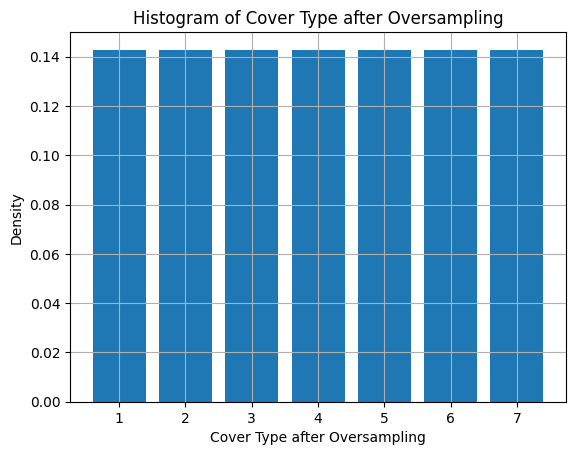

In [18]:
# Oversample
x_oversample, y_oversample = SMOTE(random_state=rand_seed, sampling_strategy="auto", k_neighbors=2).fit_resample(x_train, y_train)
x_train, x_val, y_train, y_val = train_test_split(x_oversample, y_oversample, test_size=0.2, stratify=y_oversample, random_state=rand_seed)

plot_histogram(y_oversample, label='Cover Type after Oversampling')

In [10]:
knn_cv = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [1, 3, 5, 7, 9]}, cv=5, n_jobs=-1, scoring='accuracy')
knn_cv.fit(x_train, y_train)
print("Best K:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)

Best K: {'n_neighbors': 1}
Best cross-validation score: 0.8894676417615536


In [11]:
knn_results = pd.DataFrame(knn_cv.cv_results_)
print("All cross-validation results:")
for row in knn_results.itertuples():
    print(f"k={row.params['n_neighbors']}, mean accuracy={row.mean_test_score:.4f}, \u03C3={row.std_test_score:.4f}")

All cross-validation results:
k=1, mean accuracy=0.8895, σ=0.0027
k=3, mean accuracy=0.8790, σ=0.0042
k=5, mean accuracy=0.8731, σ=0.0041
k=7, mean accuracy=0.8681, σ=0.0032
k=9, mean accuracy=0.8632, σ=0.0046
